# Classification task for FIFA dataset

This notebook will cover the necessary steps to perform the task of classification on most available datasets.
This dataset does not contain a categorical (class) metric measuring the player's overall ability, it does however contain
a continuous variable called "Overall" with the range of 0-100. We will use it to create the three classes:
- Bronze (0-64)
- Silver (65-74)
- Gold (75-100)

In order to perform a classification task, both training data to which the answers are already known, and predictions data to which
the answers are not known are required. As the FIFA does only release full datasets (meaning datasets where Overall is known) we
will take the latest dataset and strip the answers for it in order to compare the accuracy of the predictions later. 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datafoobars as dfb

We start by importing the data. All datasets are available in the /data directory. In total, there are 5 training datasets from years 2017 to 2021,
and one predictions dataset with data from 2022.

In [14]:
train_data = dfb.import_train_data()

As the goalkeepers are graded separately from the rest of the players, in this task they are to be removed.
Additionally, all irrelevant columns (including goalkeeping abilities) are to be removed.
Moreover, as it can be seen by .dropna(inplace=True), there were some anomalies present in the dataset resulting in a removal
of 707 players with incomplete statistics.
This leaves us with a 28-dimensional dataset (as one dimension is the Overall of the player which will be removed soon),
and 86935 players to learn from.

In [15]:
train_data = dfb.drop_personal_data(train_data)
train_data = dfb.drop_goalkeeper_data(train_data)
train_data = dfb.drop_categorical_data(train_data)

train_data.dropna(inplace=True)

We create the classes to which the players get assigned.

In [16]:
train_data = dfb.bin_overall_to_quality(train_data)

The task consists of two classifiers. One can be though of as the efficient one, where the learning process as well as the
predictions will be performed once on default settings. We will use it as a baseline later when comparing it with a hyperparameters
tuning approach.

We split the data into the train and test datasets, used for training on the dataset and validating the accuracy of the classifier respectively.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X = train_data.drop("Rank", axis=1)
y = train_data["Rank"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We fit the train data to the classifier.

In [18]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

We predict the test data and compare the predictions to the actual classes in the test data. 

In [19]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Bronze       0.94      0.94      0.94      6775
        Gold       0.94      0.90      0.92      2105
      Silver       0.93      0.94      0.93      8507

    accuracy                           0.93     17387
   macro avg       0.94      0.93      0.93     17387
weighted avg       0.93      0.93      0.93     17387


This approach yields a 93% accuracy score which is already high. 

We can look more in depth into the scoring process by making a confusion matrix which will count how many times
each class was predicted for each actual class. We can then plot it as a heatmap using seaborn library to obtain
more detailed prediction results.

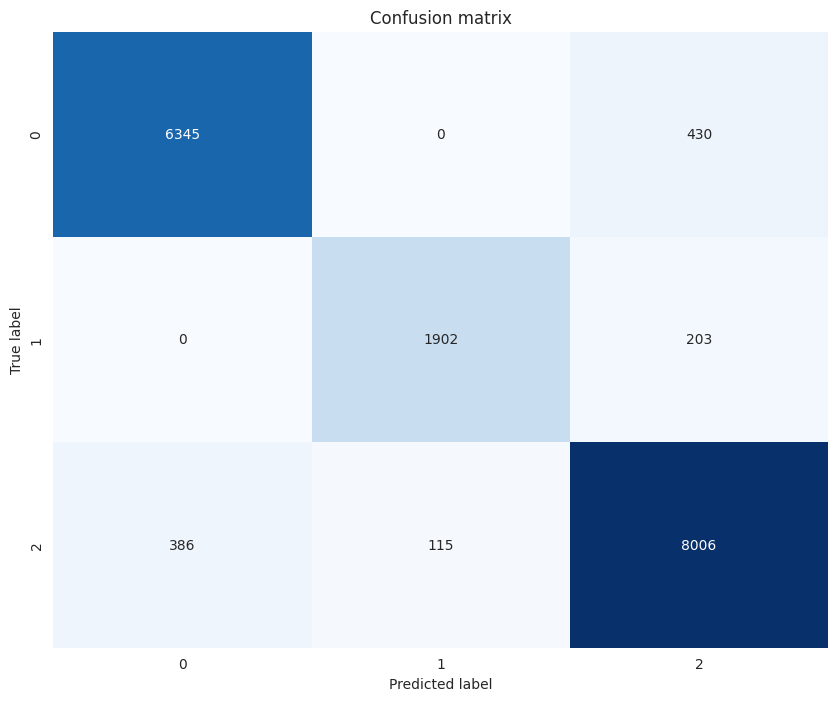

In [20]:
dfb.make_conf_matrix(y_test, y_pred)

Here we can observe some unique behaviours, namely there were no Bronze-Silver classification mistakes, while both Bronze and Silver
classes have experienced Bronze-Gold and Silver-Gold classification mistakes respectively. 

This part is only my speculation, but the league in which a player plays seems to affect their card colour as well as the overall score,
for gold players this might introduce some bias for a better card colour for weak players who are a part of a strong club,
but never play in their games.

We will now perform the exact same steps on the predictions dataset as the testing dataset. In the real world this dataset would
be without already assigned classes and the accuracy of these prediction would not be known. The accuracy would be assumed 
to be similar to the accuracy of the test dataset (assuming correct data preparation, model selection and training process).
But we get the luxury of verifying the scores with the already known answers again.

In [21]:
pred_data = pd.read_csv("data/FIFA22_official_data.csv")

pred_data = dfb.drop_personal_data(pred_data)
pred_data = dfb.drop_goalkeeper_data(pred_data)
pred_data = dfb.drop_categorical_data(pred_data)

pred_data.dropna(inplace=True)

pred_data = dfb.bin_overall_to_quality(pred_data)

X_pred = pred_data.drop("Rank", axis=1)
labels = pred_data["Rank"]

In [22]:
y_pred = rfc.predict(X_pred)
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

      Bronze       0.93      0.91      0.92      5126
        Gold       0.91      0.92      0.92      2265
      Silver       0.93      0.94      0.94      9068

    accuracy                           0.93     16459
   macro avg       0.93      0.92      0.93     16459
weighted avg       0.93      0.93      0.93     16459


We find the same overall accuracy of 93%, which is good.

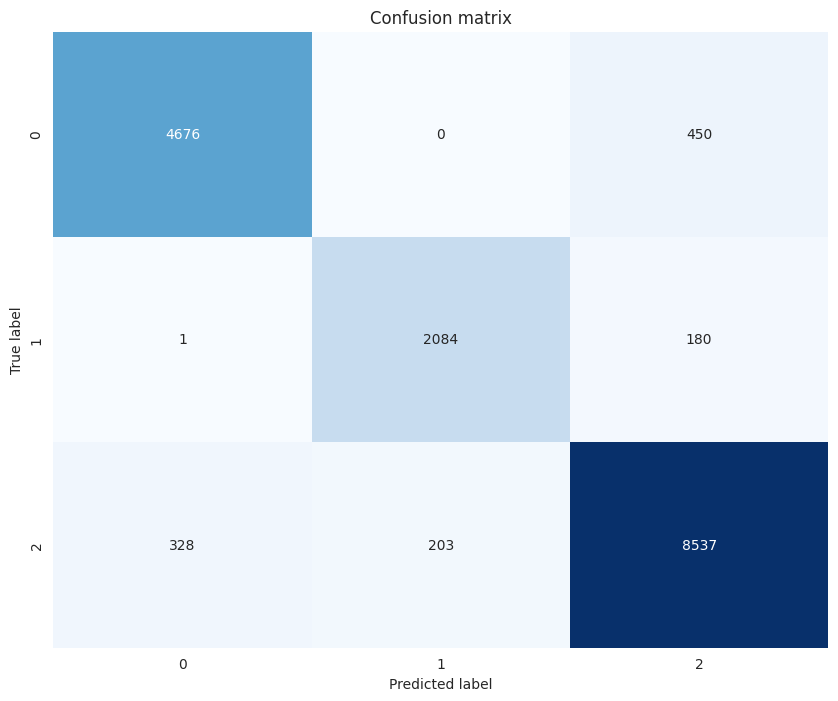

In [23]:
dfb.make_conf_matrix(labels, y_pred)

Moreover, we find that most of the same trends as with the training and testing data still apply, although there was one 
Silver-Bronze classification mistake.

For a method which uses very little resources it is still a relatively good result.
Now we will repeat the process but instead of fitting the model once on default settings we will fit a range of models
with different settings (hyperparameters) in order to find the best one which will be used later to classify the 'predictions' dataset.

In [24]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

param_dist = {
    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1600, num=100)],
    "max_depth": [int(x) for x in np.linspace(10, 70, num=10)]
}

random_search = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=3, cv=4, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

print("Best Hyperparameters: ", random_search.best_params_)

best_rfc = random_search.best_estimator_
cv_scores = cross_val_score(best_rfc, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores):.2f}%")

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] END .....................max_depth=16, n_estimators=228; total time=  52.5s
[CV] END .....................max_depth=16, n_estimators=228; total time=  53.7s
[CV] END .....................max_depth=16, n_estimators=228; total time=  54.9s
[CV] END .....................max_depth=16, n_estimators=228; total time=  55.7s
Best Hyperparameters:  {'n_estimators': 1048, 'max_depth': 63}
[CV] END .....................max_depth=36, n_estimators=694; total time= 2.6min
[CV] END .....................max_depth=36, n_estimators=694; total time= 2.6min
[CV] END .....................max_depth=36, n_estimators=694; total time= 2.6min
[CV] END .....................max_depth=36, n_estimators=694; total time= 2.6min
[CV] END ....................max_depth=63, n_estimators=1048; total time= 3.5min
[CV] END ....................max_depth=63, n_estimators=1048; total time= 3.5min
[CV] END ....................max_depth=63, n_estimators=1048; total

This method is much more resource intensive and its resource usage is relative to the number of classifiers tested.

While the fitting of the default model takes less than 20 seconds, here the cross-validation of the models takes more than 10 minutes.
We can already observe that even the best model ({'n_estimators': 1048, 'max_depth': 63}) does not perform better than the default one.
With such a massive increase in cost and no increase in performance, there is no clear justification as to why continue, but for completeness,
we will proceed and compare the results.

In [25]:
best_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=63, n_estimators=1048, random_state=42)

In [26]:
y_pred = best_rfc.predict(X_test)
print(classification_report(labels, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [16459, 17387]

We find 1 percentage point of accuracy increase over the default model. If it is worth the additional cost is solely reliant on the context
in which this classifier is used.

In [ ]:
dfb.make_conf_matrix(labels, y_pred)

Looking at the detailed results, we find similar behaviour compared to the default one, although with slightly less classification mistakes.

In [ ]:
y_pred = best_rfc.predict(X_pred)
print(classification_report(labels, y_pred))

For the prediction dataset, we find no significant differences between the expensive and the default model.

In [ ]:
dfb.make_conf_matrix(labels, y_pred)

From detailed results, we find a small decrease in classification mistakes for all cases except the singular Silver-Bronze mistake which remains.

Whether this result is satisfactory enough to run the expensive model is purely dependent on the context in which the model is used. Obviously,
better model is better, but it is not always true that better model (at any price) is more desirable than a cheaper, very comparable model.